In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from skimage import data
from skimage.color import rgb2gray
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import data, exposure
import pandas as pd
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop

In [2]:
# Caricamento del Dataset
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Divisione con insieme di validazione formato dal % del train
percentuale = 0.1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percentuale, random_state=1)

In [4]:
# Normalizzazione in 0-1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

In [5]:
######################################################################################
###################### -- PANDAS DF -- ###############################################
######################################################################################

# Riduzione di dimensionalità x train
##  print(" - Creazione Df x train - ")

# -1 -> numero righe finali impostato in automatico
# 3072 -> numero colonne che deriva da 32*32*3
# - in questo modo ogni riga corrisponde a un'immagine e ogni colonna il valore di un pixel in un'unico canale colore
x_train_flat = x_train.reshape(-1,3072)

# Creazione di una lista di nomi di pixel dal primo all'ultimo che compone un'immagine
# - utile in seguito in modo da assegnare nome a colonne del Data Frame Pandas
feat_cols = ['pixel'+str(i) for i in range(x_train_flat.shape[1])]

# Creazione del dataframe pandas
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

##  print("Shape di df_cifar : ")
##  print(df_cifar.shape)
##  print("")

# Assegnazione delle etichette ai valori nel dataframe
df_cifar['label'] = y_train

##  print("Shape del df_cifar dopo aggiunta etichette : ")
##  print(df_cifar.shape)


# Riduzione di dimensionalità x val
x_val_flat = x_val.reshape(-1,3072)
feat_cols_val = ['pixel'+str(i) for i in range(x_val_flat.shape[1])]
df_cifar_val = pd.DataFrame(x_val_flat,columns=feat_cols_val)
df_cifar_val['label'] = y_val


# Riduzione di dimensionalità x test
x_test_flat = x_test.reshape(-1,3072)
feat_cols_test = ['pixel'+str(i) for i in range(x_test_flat.shape[1])]
df_cifar_test = pd.DataFrame(x_test_flat,columns=feat_cols_test)
df_cifar_test['label'] = y_test

In [6]:
################################################################################

# Utilizzo di PCA su TRAIN

# n_components è il numero di componenti che vogliamo valutare come obiettivo
pca_train = PCA(0.9)

# Estrazione di tutti i dati tranne ultima colonna che contiene le etichette
# - principalComponents_cifar è il risultato della riduzione di dimensionalità
principalComponents_cifar = pca_train.fit_transform(df_cifar.iloc[:,:-1])

print("\n Numero caratteristiche individuate : ",pca_train.n_components_)

################################################################################

# Utilizzo di PCA su TEST
pca_test = PCA(n_components=pca_train.n_components_)
principalComponents_cifar_test = pca_test.fit_transform(df_cifar_test.iloc[:,:-1])

################################################################################

# Utilizzo di PCA su VAL
pca_val = PCA(n_components=pca_train.n_components_)
principalComponents_cifar_val = pca_val.fit_transform(df_cifar_val.iloc[:,:-1])



 Numero caratteristiche individuate :  99


In [7]:
################################################################################

##  print("Assegnazione nome colonne a DF ottenuto x TRAIN")

# DF = Data Frame

# Creazione di nuovo data frame
# - partendo da quello appena ottenuto
# - vengono aggiunti i nomi dei valori contenuti
pca_cifar_Df = pd.DataFrame(data = principalComponents_cifar)

##  print("")

# Aggiunta della colonna con le etichette dei dati relativi
# - Lo faccio in una copia del dataframe così da averne uno senza etichette
##  print("Creazione dataframe con etichette come ultima colonna")
pca_cifar_Df_con_etichette = pca_cifar_Df.copy()
pca_cifar_Df_con_etichette['y'] = y_train


################################################################################

print("Assegnazione nome colonne a DF ottenuto x TEST")
pca_cifar_Df_test = pd.DataFrame(data = principalComponents_cifar_test)
print("")
print("Creazione dataframe con etichette come ultima colonna x test")
pca_cifar_Df_con_etichette_test = pca_cifar_Df_test.copy()
pca_cifar_Df_con_etichette_test['y'] = y_test

################################################################################

print("Assegnazione nome colonne a DF ottenuto x val")
pca_cifar_Df_val = pd.DataFrame(data = principalComponents_cifar_val)
print("")
print("Creazione dataframe con etichette come ultima colonna x val")
pca_cifar_Df_con_etichette_val = pca_cifar_Df_val.copy()
pca_cifar_Df_con_etichette_val['y'] = y_val

Assegnazione nome colonne a DF ottenuto x TEST

Creazione dataframe con etichette come ultima colonna x test
Assegnazione nome colonne a DF ottenuto x val

Creazione dataframe con etichette come ultima colonna x val


In [8]:
# - Preparazione dei dataset filtrati

# Prova di divisione in due classi
primaEtichetta = 4
secondaEtichetta = 9

df_filtrato_etichettato = pca_cifar_Df_con_etichette[pca_cifar_Df_con_etichette['y'].isin([primaEtichetta,secondaEtichetta])]

df_filtrato_etichettato_test = pca_cifar_Df_con_etichette_test[pca_cifar_Df_con_etichette_test['y'].isin([primaEtichetta,secondaEtichetta])]

df_filtrato_etichettato_val = pca_cifar_Df_con_etichette_val[pca_cifar_Df_con_etichette_val['y'].isin([primaEtichetta,secondaEtichetta])]

# Filtro i dati delle etichette
y_train_filtrato = y_train[np.isin(y_train, [primaEtichetta,secondaEtichetta])]
y_test_filtrato = y_test[np.isin(y_test, [primaEtichetta,secondaEtichetta])]
y_val_filtrato = y_val[np.isin(y_val, [primaEtichetta,secondaEtichetta])]

# Eliminazione colonna etichette
df_filtrato = df_filtrato_etichettato.copy()
df_filtrato = df_filtrato.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_test = df_filtrato_etichettato_test.copy()
df_filtrato_test = df_filtrato_test.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_val = df_filtrato_etichettato_val.copy()
df_filtrato_val = df_filtrato_val.drop(columns=['y'])

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from keras.layers import LeakyReLU


# Vettore delle etichette creato come vettore one-shot
y_train = to_categorical(y_train_filtrato)
y_test = to_categorical(y_test_filtrato)
y_val = to_categorical(y_val_filtrato)

# Print delle dimensioni dei dati che utilizzo
#print("df_filtrato shape : " , df_filtrato.shape)
#print("y_train_filtrato shape : " , y_train_filtrato.shape)
#print("y_train shape : " , y_train.shape)

# Numero di classi da classificare
num_classes = len(y_train[0])

# Numero di elementi da utilizzare per aggiornamento pesi
batch_size = 64 #512 #128

# Epoche su cui basare l'apprendimento
epochs = 20 #20 #100

# Definizione degli strati della rete
model = Sequential()
model.add(Dense(1024, activation=LeakyReLU(alpha=0.1), input_shape=(pca_train.n_components_,)))
model.add(Dense(1024, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(512, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(256, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(num_classes, activation='softmax'))

# Assemblaggio del modello
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

# Creazione callback x earlystopping 
callback = EarlyStopping(monitor='val_loss', patience=4)

# Esecuzione allenamento e calcolo affidabilità
print("\n - TRAIN - ")
history = model.fit(df_filtrato, y_train,batch_size=batch_size,epochs=epochs,verbose=1, validation_data=(df_filtrato_val, y_val), callbacks=[callback])


 - TRAIN - 
Epoch 1/20


c:\Users\domen\Desktop\prova\.venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\domen\Desktop\prova\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6199 - loss: 0.2237 - precision: 0.7260 - recall: 0.5034 - val_accuracy: 0.8173 - val_loss: 0.0821 - val_precision: 0.8187 - val_recall: 0.8163
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.0580 - precision: 0.8867 - recall: 0.8857 - val_accuracy: 0.8038 - val_loss: 0.0901 - val_precision: 0.8038 - val_recall: 0.8038
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9079 - loss: 0.0468 - precision: 0.9078 - recall: 0.9078 - val_accuracy: 0.8212 - val_loss: 0.0924 - val_precision: 0.8219 - val_recall: 0.8212
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9232 - loss: 0.0394 - precision: 0.9233 - recall: 0.9232 - val_accuracy: 0.8010 - val_loss: 0.1039 - val_precision: 0.8010 - val_recall: 0.8010
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9420 - loss: 0.0308 - precision: 0.9420 - recall: 0.9420 - val_accuracy: 0.8173 - val_loss: 0.0936 - val_

In [26]:
print("\n - VALUTAZIONE SU TEST - ")
evaluation = model.evaluate(df_filtrato_test,  y_test, verbose=2)


 - VALUTAZIONE SU TEST - 
63/63 - 0s - 2ms/step - accuracy: 0.7850 - loss: 0.1206 - precision: 0.7850 - recall: 0.7850


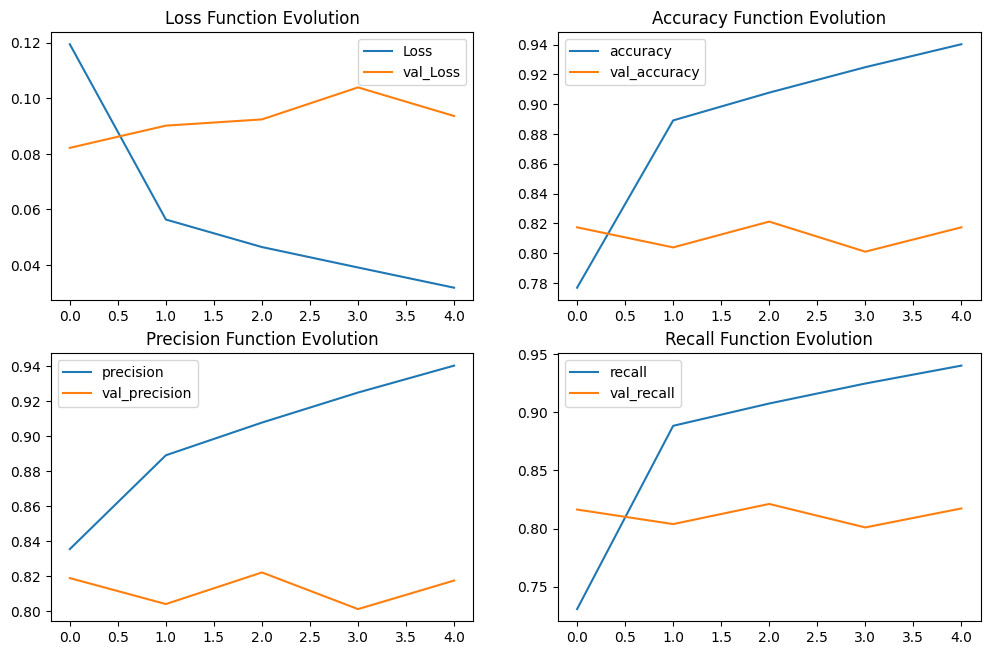

In [27]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7842 - loss: 0.1174 - precision: 0.7842 - recall: 0.7842
Test Accuracy : 78.50%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


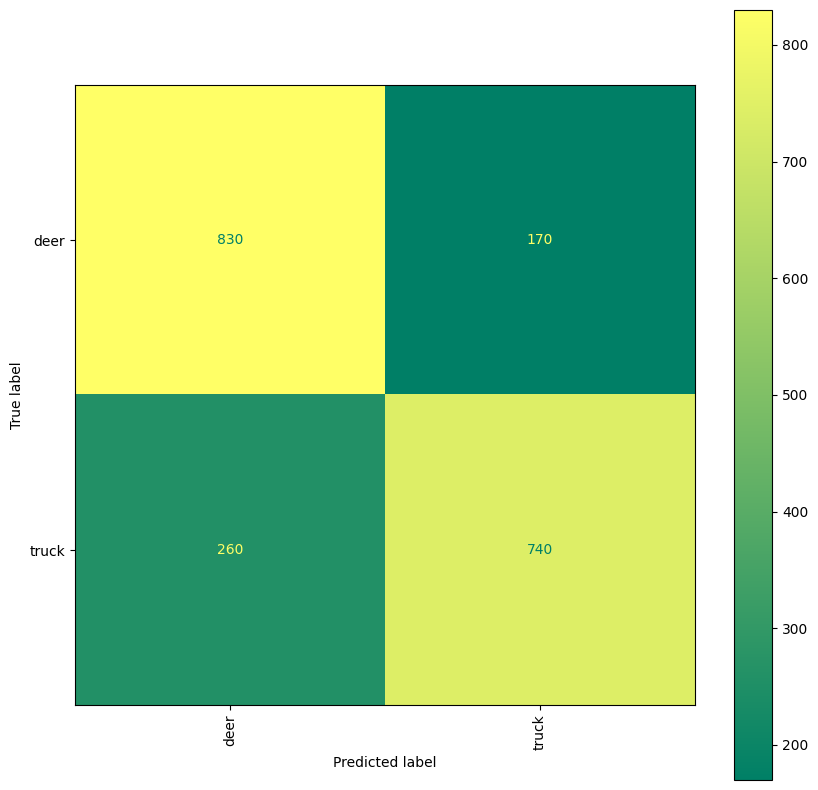

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

evaluation = model.evaluate(df_filtrato_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(df_filtrato_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_x_grafico = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_x_grafico, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels[primaEtichetta],labels[secondaEtichetta]])

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()